# End-to-end overview of wrfhydropy: Simulation evaluation

The goal of this example is to show both the WRF-Hydro model API (application programming interface) and the ability of `wrfhydropy` to interact with model inputs and outputs: end-to-end capabilities all within python.  The vision of of `wrfhydropy` is to work seamlessly in python across the input, setup, run, and analysis phases of the model life cycle to support reproducible science without stifling the user. This example aims to illustrate this.


Model inputs receive little attention here but can easily be manipulated using the `xarray` library which provides the general strategy for working with model inputs and outputs in `wrfhydropy` (sometimes in conjunction with `pandas`). The evaluation and plotting of the output at the end of the example provide some flavor of using `xarray`. Particularly for users new to python, it is worth noting that the `xarray` approach is attractive because it provides a path to data export from python at every step. This allows users to choose points of departure from the confines of `wrfhydropy`. 


The main focus of this example is the API, in particular the core objects which build a Simulation object: Model, Domain, Job, and optionally Scheduler. Building the Simulation object is key to understanding how to build the more complicated objects which contain it, to be covered separately: Ensembles, Cycles, and EnsembleCycles. The two main differences in `wrfhydropy` as compared to a shell-centered approach are the way it treats the concepts of "namelists" and "jobs". These are covered at length.

Note: This example provides zero scientific content.

## 0. Overview of this overview
At a high level, this example covers the following: 

1. Preliminaries
    * Python libraries
    * Local model repository clone: `wrf_hydro_nwm_public`
    * Local croton_NY domain downloaded from the cloud
1. Namelists and configurations in wrfhydropy
    * The mind is bent for existing users of WRF-Hydro
    * Model-side namelists
    * Domain-side namelist "patches"
1. Compile options
1. Configuration
1. Domain object
1. Model object and compile
1. Job object
    * Further brain injuries for existing WRF-Hydro users
1. Scheduler object
    * Run modes: interactive, scheduled, and team (not shown here)
1. Simulation object: interactive run
    * add Domain, Model, Jobs
    * compose the simulation to disk
    * interactive run
1. Simulation object: scheduled run
    * add Domain, Model, Jobs, Scheduler
1. Simulations on disk and in memory
    * collecting output
    * opening output    
1. Engineering test
1. Evaluation syntax: goodness of fit
    * bulk
    * group_by=feature_id
    * export stats to netcdf file
1. Plot
    * Total capitulation to matplotlib

## 1. Preliminaries
Steps to gather the required inputs and setup where the example will be run.

### Python libraries
First define the python libraries we will use _in this example_. The `wrfhydropy` library should have previously been installed, see [installing](nori.com) for help, and its dependencies cover what is used here.

In [1]:
import os
import pandas as pd
import pathlib
import pickle
from pprint import pprint
import shlex
import subprocess
import sys
import wrfhydropy

/glade/work/jamesmcc/python_envs/368_/lib/python3.6/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### Model repository
A clone of the `wrf_hydro_nwm_public` needs to be available locally.

In [2]:
model_repo = pathlib.Path(
    '/glade/u/home/jamesmcc/WRF_Hydro/wrf_hydro_nwm_public')

If this does not exist somewhere on your machine, then
```
cd /path/to/desired_location
git clone https://github.com/NCAR/wrf_hydro_nwm_public.git
```
would result in the previous code block being:
```
model_repo = pathlib.Path(
    '/path/to/desired_location/wrf_hydro_nwm_public')
```   

The branch of the repository which is checked out will be the one used by `wrfhydropy`. If in doubt, `git checkout master` inside `/path/to/desired_location/wrf_hydro_nwm_public/` will suffice for this example.  

Next, we will establish an experiment directory and create it. This directory will contain where wrfhydropy writes this example to disk:

In [3]:
experiment_dir = pathlib.Path(
    '/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example')
if not experiment_dir.exists():
    os.mkdir(str(experiment_dir))
os.chdir(str(experiment_dir))

### Domain retrieval from the cloud
This section is not important to understanding `wrfhydropy`, it's just grabbing the model domain from the cloud. Only the first line is necessary to understand, it tels where the domain files are located. We use code in the `wrf_hydro_nwm_public` repository to provide us the `croton_NY` test domain. When a local copy of it does not previously exist, we will download the `croton_NY` domain in to a subdirectory of the experiment directory, the `domain_dir`. 

In [4]:
domain_dir = experiment_dir / 'domain'
if not domain_dir.exists(): 
    sys.path.append(str(model_repo / 'tests/local/utils'))
    from gdrive_download import download_file_from_google_drive
    file_id = '1xFYB--zm9f8bFHESzgP5X5i7sZryQzJe'
    file_target = 'gdrive_testcase.tar.gz'
    download_file_from_google_drive(
        file_id, 
        str(experiment_dir.joinpath(file_target)))
    untar_cmd = 'tar -xf ' + file_target + '; mv example_case domain'
    subprocess.run(
        untar_cmd, 
        shell=True,
        cwd=str(experiment_dir))

## 2. Namelists and configurations in wrfhydropy

Now that we have the model repository and a model domain locally, we can get started with `wrfhydropy`. We go straight to the main structure or concept that `wrfhydropy` introduces and which users must understand: namelists. The `wrfhydropy` package introduces some complexity to the concept of the  namelists for the purposes of being able to easily swap domains while maintaining a certain "model configuration". Or vice-versa, one may also want to swap configurations while maintining a particular domain. The namelist approach in `wrfhydropy` supports this flexibility while also offering a mechanism for collecting sets of related namelists into a smaller set of files than would otherwise be needed.

For example, there is a configuration known as the "Analysis and Assimilation" configuration of the National Water Model. For the purposes of a single execution of the model, a configuration is defined by: 1) compile-time options, 2) run-time options, in Fortran these are namelists (`hydro.namelist` and `namelist.hrldas`), and 3) input files (such as domain files defined at run-time or files implicit in the code such as tables). This begs the question: What is the "Analysis and Assimilation" configuration for a different domain? The parsing of namelist files by `wrfhydropy` provides an answer to the question: how do we maintain a "configuraton" on a different domain (and vice-versa).

Let us be clear that, in terms of the operational execution of the NWM, the state of the model is maintained by a set of process beyond running the model once with the 3 things comprising a configuraton above. Sepcifically, the model state is given in the analysis and forecast modes by "cycling" the model with ever changing forcing and observation files. Here we are not referring to the cycling workflow of the operational model. This is addressed in later examples. Here we confine our attention to serial (in time) execution of the model with fixed inputs, what we will term a "simulation".

To tackle the notion of configuration across different domains, `wrfhydropy` separates the standard WRF-Hydro namelists in to two parts: model-side and domain-side namelists. Because WRF-Hydro begins with 2 namelist files, the result is 4 namelist files, as illustrated in the table below. 


| WRF-Hydro namelist file |=| wrfhydropy model-side *example* file |+| wrfhydropy domain-side *example* file |+| config name
|-------------------------|-|--------------------------------------|-|---------------------------------------|-|------------
| namelist.hrldas         |=| hrldas_namelists.json                |+| hrldas_namelist_patches.json          |+| 'some_config'
| hydro.namelist          |=| hrldas_namelists.json                |+| hydro_namelist_patches.json           |+| 'some_config'


The user presents `wrfhydropy` with the files in two right-hand columns and it creates the files in the left-hand columns, which is what the model requires at run time. The files in the left-hand column have specific names, which are hard-wired in the WRF-Hydro code. The JSON files supplied to `wrfhydropy` do not need specific names, the names here are the conventions we have used in `wrf_hydro_nwm_public` (model-side) and in the `croton_NY` domain (domain-side) which has been downloaded. The names of these files are presented to `wrfhydropy` at its run time. 

Moreover, the files supplied to `wrfhydropy` potentially contain multiple named configurations in either or both of the respective model- and domain- sides of the namelists. To actually generate the namelist files needed by the model, `wrfhydropy` also needs a configuration name to pull the specific, desired namelists from the JSON files before combining the two sides of the namelists to present to the model. In this way, the JSON namelist files provide a way of saving multiple namelists (more importantly, diffs from a single base namelist in each) which may be a relevant collection for a given experiment or some other purpose. The collection of configurations in the specific JSON files used in this example are intended for the purposes of `wrf_hydro_nwm_public` model testing (they are not identical to the NWM operational configurations) and are used here for convenience rather than a specific purpose.

### Model-side namelists
As mentioned, for testing purposes we have created model-side namelists in `wrf_hydro_nwm_public`. We can examine those in our clone of the repository. Notice the names of all the available configurations in the file, starting with "base", from which the remaining configurations are differences:

In [5]:
hrldas_model_side_file = model_repo / 'trunk/NDHMS/hrldas_namelists.json'
with open(hrldas_model_side_file, 'r') as file:
    print(file.read())

{
    "base": {
        "noahlsm_offline": {
            "btr_option": 1,
            "canopy_stomatal_resistance_option": 1,
            "dynamic_veg_option": 4,
            "forcing_timestep": "NULL_specified_in_domain.json",
            "frozen_soil_option": 1,
            "glacier_option": 2,
            "hrldas_setup_file": "NULL_specified_in_domain.json",
            "indir": "NULL_specified_in_domain.json",
            "khour": 144,
            "noah_timestep": 3600,
            "nsoil": 4,
            "outdir": "./",
            "output_timestep": 3600,
            "pcp_partition_option": 1,
            "radiative_transfer_option": 3,
            "restart_filename_requested": "NULL_specified_in_domain.json",
            "restart_frequency_hours": 24,
            "rst_bi_in": 0,
            "rst_bi_out": 0,
            "runoff_option": 3,
            "snow_albedo_option": 1,
            "soil_thick_input": [0.1, 0.3, 0.6, 1.0],
            "spatial_filename": "NULL_specified_in_

This is a JSON file with hierarchical data structures similar to a python dictionary. The "base" configuration sets the basis for the other named configuratons which follow, which only specify differences from this base. You can see that the "base" config is identical to both the `nwm_ana` and "nwm_long_range" configurations (among others). Differences from "base" are succinctly summarized in the named configurations. 

The next things to notice are lines like: `"forcing_timestep": "NULL_specified_in_domain.json"`. This value of the field indicates that it is considered a domain-side option and its value is to come from the domain-side file (and the specified configuration for that file). Before looking at the domain-side namelists, let's take a look a the other model-side namelist corresponding to `hydro.namelist`. It is treated exactly as for the `namelist.hrldas` above. 

In [6]:
hydro_model_side_file = model_repo / 'trunk/NDHMS/hydro_namelists.json'
with open(hydro_model_side_file, 'r') as file:
    print(file.read())

{
    "base": {
        "hydro_nlist": {
            "aggfactrt": 4,
            "channel_option": 2,
            "chanobs_domain": 1,
            "chanrtswcrt": 1,
            "chrtout_domain": 1,
            "chrtout_grid": 1,
            "compound_channel": true,
            "dtrt_ch": 300,
            "dtrt_ter": 10,
            "dxrt": 250,
            "frxst_pts_out": 0,
            "geo_finegrid_flnm": "NULL_specified_in_domain.json",
            "geo_static_flnm": "NULL_specified_in_domain.json",
            "gw_restart": 1,
            "gwbaseswcrt": 4,
            "gwbuckparm_file": "NULL_specified_in_domain.json",
            "hydrotbl_f": "NULL_specified_in_domain.json",
            "igrid": 1,
            "io_config_outputs": 0,
            "io_form_outputs": 4,
            "land_spatial_meta_flnm": "NULL_specified_in_domain.json",
            "lsmout_domain": 1,
            "nsoil": 4,
            "order_to_write": 1,
            "out_dt": 60,
            "outlake": 1,
  

Again, the JSON file provides a "base" namelist and the following configuratons only specifiy differences. And again, domain-side values are indicated by "NULL_specified_in_domain.json".

A final point is that model-side JSON namelists can be any similarly structured JSON file. There is nothing particularly special about these namelists which are located in the model repository. They exist specifically to support automated model testing. As will be pointed out below, the user can tell `wrfhydropy` the location of the JSON namelist files to use (though it looks for these specific files in the model repository by default). Generally, an experiment will create it's own model-side and domain-side JSON namelists. Only two such model-side JSON namelist files are necessary while 2 domain-side namelists are necessary _for each domain_.

### Domain-side namelists

Just as for model-side namelists, the domain side namelists provide a "base" configuration and 

In [7]:
hrldas_domain_side_file = domain_dir / 'hrldas_namelist_patches.json'
with open(hrldas_domain_side_file, 'r') as file:
    print(file.read())

{
    "base": {            
        "noahlsm_offline": {
            "hrldas_setup_file": "./NWM/DOMAIN/wrfinput_d01.nc",
            "khour": 144,
            "indir": "./FORCING",
            "forcing_timestep": 3600,
            "spatial_filename": "./NWM/DOMAIN/soil_properties.nc",
            "restart_filename_requested": "./NWM/RESTART/RESTART.2011082600_DOMAIN1",
            "start_year": 2011,
            "start_month": 8,
            "start_day": 26,
            "start_hour": 0,
            "start_min": 0
        },
        "wrf_hydro_offline": {
            "forc_typ": 1
        }
    },
    "nwm_ana": {
        "noahlsm_offline": {},
        "wrf_hydro_offline": {}
    },

    "nwm_short_range" : {
        "noahlsm_offline": {},
        "wrf_hydro_offline": {}
    },

    "nwm_medium_range" : {
        "noahlsm_offline": {},
        "wrf_hydro_offline": {}
    },

    "nwm_long_range" : {
        "noahlsm_offline": {
            "hrldas_setup_file": "./NWM/DOMAIN_LR/wrfinput

We do not show the hydro_namelist_patches.json, it is very similar and can be examined by the user. 

To summarize the namelist handling of `wrfhydropy`: while `wrfhydropy` breaks the native WRF-Hydro namelists into parts, the files we use to build the native namelists may contain many named configurations which can be specified as deviations from a `base` config in that file. The model-side namelists contain the full set of WRF-Hydro options and where an option is considered domain-side that option's value is set to `NULL_specified_in_domain.json`. The domain-side namelist contains only the options relevant to the domain, for the base and each named configuration.

As mentioned, each "domain" or set of domain files will require it's own domain-side namelits which are specific to the files in that domain. If multiple domains are generated using the same filenames and file structure conventions then these JSON namelists can be identical across the multiple domains and only one of each domain-side JSON file is required.

## 3. Compile Options
The definition of a configuration above included compile-time options in addition to the run-time options and input files covered by the namelists above. Similarly to the namelists, the compile options for named-configurations' are strored in JSON files and retrieved by name by `wrfhydropy`. However, because compile options relate only to the model, all compile time options are necessarily model-side. There is only one compile options file. 
The compile options JSON file also does NOT follow the convention of using a "base" namelist and diffs. The compile options JSON file just uses configuration names as this level of complexity has never seemed warranted in this case.

Here is contents of the compile options file that comes with the model repository:

In [8]:
compile_options_file = model_repo / 'trunk/NDHMS/compile_options.json'
with open(compile_options_file, 'r') as file:
    print(file.read())

{
    "nwm": {
        "WRF_HYDRO": 1,
        "HYDRO_D": 0,
        "SPATIAL_SOIL": 1,
        "WRF_HYDRO_RAPID": 0,
        "WRFIO_NCD_LARGE_FILE_SUPPORT": 1,
        "NCEP_WCOSS": 0,
        "WRF_HYDRO_NUDGING": 1
    },

    "gridded": {
        "WRF_HYDRO": 1,
        "HYDRO_D": 0,
        "SPATIAL_SOIL": 1,
        "WRF_HYDRO_RAPID": 0,
        "WRFIO_NCD_LARGE_FILE_SUPPORT": 1,
        "NCEP_WCOSS": 0,
        "WRF_HYDRO_NUDGING": 0
    },

    "gridded_no_lakes": {
        "WRF_HYDRO": 1,
        "HYDRO_D": 0,
        "SPATIAL_SOIL": 1,
        "WRF_HYDRO_RAPID": 0,
        "WRFIO_NCD_LARGE_FILE_SUPPORT": 1,
        "NCEP_WCOSS": 0,
        "WRF_HYDRO_NUDGING": 0
    },

    "reach": {
        "WRF_HYDRO": 1,
        "HYDRO_D": 0,
        "SPATIAL_SOIL": 1,
        "WRF_HYDRO_RAPID": 0,
        "WRFIO_NCD_LARGE_FILE_SUPPORT": 1,
        "NCEP_WCOSS": 0,
        "WRF_HYDRO_NUDGING": 0
    }
}



As with the namelist JSON files, the compile options JSON file can be any file and its path is specified in the initialization of `wrfhydropy` `Model` objects. The init method also provides a means for overiding compile options.

## 4. Configuration

We will use the named configuration `nwm_ana` which was seen in the above namelists. 

In [9]:
config = 'nwm_ana'

The following detail may not be obvious until we get to `Simulation.add()`, but note that `wrfhydropy` requires the same configuration name be used for `Model` and `Domain` objects when they are combined into a `Simulation` object. The flexibility of allowing different named configurations for `Model` and `Domain` presents risks that we haven't deemed acceptable. 

## 5. Domain object
The domain object contains all the domain-side information necessary to run the model. To instantiate or initalize (`__init__`) a `Domain` object, help is available on-line (in python) and is the same information presented at our (readthedocs page)[https://wrfhydropy.readthedocs.io/en/latest/]. This shows the arguments availble to the `__init__` method, with some description:

In [10]:
help(wrfhydropy.Domain)

Help on class Domain in module wrfhydropy.core.domain:

class Domain(builtins.object)
 |  Class for a WRF-Hydro domain, which constitutes all domain-specific files needed for a
 |  setup.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, domain_top_dir:str, domain_config:str, compatible_version:str=None, hydro_namelist_patch_file:str='hydro_namelist_patches.json', hrldas_namelist_patch_file:str='hrldas_namelist_patches.json')
 |      Instantiate a Domain object
 |      Args:
 |          domain_top_dir: Parent directory containing all domain directories and files.
 |          domain_config: The domain configuration to use, options are 'NWM',
 |              'Gridded', or 'Reach'
 |          compatible_version: String indicating the compatible model version, required if no
 |          .version file included in domain_top_dir.
 |          hydro_namelist_patch_file: Filename of json file containing namelist patches for
 |          hydro namelist
 |          hrldas_namelist_patch_file:

To create an object containing the domain-side, we'll use just the required arguments. The implicit paths to the JSON namelist patch (domain-side) files is at the top level of the domain and the names are the defaults. We could give different paths for both of these files.  The 

In [11]:
domain = wrfhydropy.Domain(
    domain_top_dir=domain_dir,
    domain_config=config)
domain

This last line simply indicates that no useful `__repr__` (representation method) has been implemented for the domain object. One can examine `wrfhydropy` objects via the "dunder dict" mechanism. This will be illustrated for the `Model` object.

## 6. Model object

The environment used to build and run the model is not managed by `wrfhydropy` directly (however relevant parts of it are saved into the `Model` object, as shown below). Here we examine the modules used on `cheyenne` to compile the model.

In [12]:
print(subprocess.run('module list', shell=True, stderr=subprocess.PIPE).stderr.decode('utf-8'))


Currently Loaded Modules:
  1) intel/18.0.5   3) impi/2018.4.274   5) ncarcompilers/0.5.0
  2) netcdf/4.7.3   4) ncarenv/1.3       6) nccmp/1.8.2.1

 




The above shows that we are using the intel compiler for this example. You may need to change this to your machine.

In [13]:
model = wrfhydropy.Model(
    model_repo / 'trunk/NDHMS',
    compiler='ifort',
    model_config=config)
model

What is in a model object? Let's take a look at the disctionary representation of the object (the "dunder dict") BEFORE we compile:

In [14]:
pprint(model.__dict__)

{'compile_dir': None,
 'compile_log': None,
 'compile_options': {'HYDRO_D': 0,
                     'NCEP_WCOSS': 0,
                     'SPATIAL_SOIL': 1,
                     'WRFIO_NCD_LARGE_FILE_SUPPORT': 1,
                     'WRF_HYDRO': 1,
                     'WRF_HYDRO_NUDGING': 1,
                     'WRF_HYDRO_RAPID': 0},
 'compile_options_config_file': 'compile_options.json',
 'compiler': 'ifort',
 'configure_log': None,
 'git_hash': '5913c15572a90556f26702dd6ff1d16c7ffb63df',
 'hrldas_namelist_config_file': 'hrldas_namelists.json',
 'hrldas_namelists': {'noahlsm_offline': {'btr_option': 1,
                                          'canopy_stomatal_resistance_option': 1,
                                          'dynamic_veg_option': 4,
                                          'forcing_timestep': 'NULL_specified_in_domain.json',
                                          'frozen_soil_option': 1,
                                          'glacier_option': 2,
            

There is a lot of information contained in this `Model` object. Even more information is stored there after the model is compiled.

When the model is compiled, a `compile_dir` is required. It is VERY IMPORTANT to note that the model is actually compiled as per normal in the `model_repo_path/trunk/NDHMS`. The `compile_dir` is used to save the results of that (normal WRF-Hydro) compile along with a `pickle` (disk representation/serialization) of the `wrfhydropy` `Model` object. After compile, the `Model` object in memory and the copy of it stored to disk are identical. If we've already compiled the model and the `compile_dir` exists, we can avoid recompiling the model.

In [15]:
compile_dir = experiment_dir / 'compile'
if not compile_dir.exists():
    model.compile(compile_dir)
else: 
    model = pickle.load(compile_dir.joinpath('WrfHydroModel.pkl').open('rb'))
    # Caveat here, the config used for compiling is baked into the restored model object. A change/fix to this is easy to implement... 

/glade/work/jamesmcc/python_envs/368_/lib/python3.6/site-packages/wrfhydropy-0.0.18-py3.6.egg/wrfhydropy/core/model.py:193: UserWarning: /glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/compile directory does not exist, creating
  warnings.warn(str(self.compile_dir.absolute()) + ' directory does not exist, creating')


Model successfully compiled into /glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/compile


If one wants to recompile, it's necessary to delete the `compile_dir`. 

Note: Be careful with the unpickling above. Especially note that the configuration is baked into the unpickled model object and currently requires manual intervention to be changed. A model.restore() method or the like (init from file) could reduce pitfalls here and will likely be added to the API.

Let's examine what's in the compile directory:

In [16]:
sorted(compile_dir.glob('*'))

[PosixPath('/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/compile/.uid'),
 PosixPath('/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/compile/WrfHydroModel.pkl'),
 PosixPath('/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/compile/wrf_hydro.exe')]

The model executable, `wrf_hydro.exe`, is stored along with the serialization of the `Model` object. The `.uid` file stores the object id in an attempt to reduce mangling of the executable relative to the serialized model object.

Let's look at the `Model` object now, AFTER compiling:

In [17]:
pprint(model.__dict__)

{'compile_dir': PosixPath('/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/compile'),
 'compile_log': CompletedProcess(args=['/bin/bash', '-c', './configure ifort; ./compile_offline_NoahMP.sh /glade/u/home/jamesmcc/WRF_Hydro/wrf_hydro_nwm_public/trunk/NDHMS/compile_options.sh'], returncode=0, stdout=b'Configured: ifort\nconfigure: Sourcing /glade/u/home/jamesmcc/WRF_Hydro/wrf_hydro_nwm_public/trunk/NDHMS/compile_options.sh for the compile options.\nmake[1]: Entering directory \'/glade/u/home/jamesmcc/WRF_Hydro/wrf_hydro_nwm_public/trunk/NDHMS/CPL/NoahMP_cpl\'\nrm -f *.o *.mod *.stb *~ Noah_hrldas_beta\nmake[1]: Leaving directory \'/glade/u/home/jamesmcc/WRF_Hydro/wrf_hydro_nwm_public/trunk/NDHMS/CPL/NoahMP_cpl\'\n(make -f Makefile.comm clean)\nmake[1]: Entering directory \'/glade/u/home/jamesmcc/WRF_Hydro/wrf_hydro_nwm_public/trunk/NDHMS\'\n(cd IO; make -f Makefile clean)\nmake[2]: Entering directory \'/glade/u/home/jamesmcc/WRF_Hydro/wrf_hydro_nwm_public/trunk/NDHMS/IO\'\nrm -f 

The above is a treasure trove of information about the "model" when problems arise. This information is key for doing reproducible science.

For some applications it is worth noting the `table_files` entry of the `Model` object. While there is no argument to the `Model` initialization specifying alternative table files, the ones supplied by the compile process can be altered *after* compile. 

## 7. Job object

The concept of a job is formalized in `wrfhydropy`  by the `Job` object and this can have surprising consequences compared to the relatively ad hoc notion used when running the model otherwise. The job has 2 main functions:

1) provide a time focused intervention into the configuration, including both the model- and domain- sides of the namelists. Without this we'd have to have a configuration for each period of time we want to run the model. As an additional convenience, restart and output file frequencies may also be controlled by the job.

2) specify how the model is to be executed by the system. This can vary depending on the flavor of MPI used to compile and execute the model and the number of processors to use.

Additional functionality:

3) execute user-defined commands immediately prior to and immediately after the model execution.

The arguments to instatiation of a Job object reveal its scope:

In [18]:
help(wrfhydropy.Job)

Help on class Job in module wrfhydropy.core.job:

class Job(builtins.object)
 |  A Job represents run-time specific information for a given WRF-Hydro run. A Simulation
 |  consists of one or more jobs. For example, adding multiple Jobs can be used to split a
 |  Simulation into multiple runs to limit the wall-clock duration of each individual run.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, job_id:str, model_start_time:Union[str, datetime.datetime]=None, model_end_time:Union[str, datetime.datetime]=None, restart_freq_hr:Union[int, dict]=None, output_freq_hr:Union[int, dict]=None, restart:bool=True, restart_file_time:Union[str, datetime.datetime, dict]=None, restart_dir:Union[str, pathlib.Path, dict]=None, exe_cmd:str=None, entry_cmd:str=None, exit_cmd:str=None)
 |      Instatiate a Job object.
 |      Args:
 |      job_id: A string identify the job
 |      model_start_time: The model start time to use for the WRF-Hydro model run. Can be
 |          a pandas.to_datetime compa

A common example is a long model run which must be broken up into several jobs because of walltime limitations of schedulers. With `wrfhydropy` you can skip the non-reproducble interventions into the namelists in your run directory. Instead you can create and add multiple `Jobs` to your simulation before you run it. These jobs will run sequentially and, if you a `Scheduler` object, can be submitted to the queue as dependent jobs. This is shown below. Also shown below is how the provenance and artifacts related to the individual jobs are be stored in subdirectories of the simulation run directory with distinct job names. This means that all jobs added to a `Simulation` need different `job_id`s.

For now we create 2 jobs which use the same execution command. The second job starts where the first job ends and looks for its restarts in the run directory.

In [19]:
exe_cmd = 'mpirun -np 1 ./wrf_hydro.exe'

job_24hr = wrfhydropy.Job(
    job_id='24hr',
    exe_cmd = exe_cmd,
    model_start_time = '2011-08-26',
    model_end_time='2011-08-27',
    restart_freq_hr=24,
    output_freq_hr=1)

job_145hr = wrfhydropy.Job(
    job_id='144hr',
    exe_cmd = exe_cmd,
    model_start_time = '2011-08-27',
    model_end_time='2011-09-02',
    restart_freq_hr=24,
    output_freq_hr=1,
    restart_dir='.')

## 8. Scheduler object
In this example, two run modes of `wrfhydropy` will be demonstrated: interactive and scheduled runs. A third run mode will be presented in a later example: teams runs. This latter mode is mean for executing lots of small jobs (each not exceeding a single node) simulataneously over multiple nodes (such as ensembles or forecasts).

Here we show the `PBSCheyenne` scheduler. PBS is notoriously different on different machines, so this object is tied to a specific machine. SLURM schedulers have been developed and used for `wrfhydropy` but need tested before they become part of the master branch. Please inquire if you need a SLRUM scheduler.

The scheduler takes common information and is described in its `help`.

In [20]:
scheduler = wrfhydropy.schedulers.PBSCheyenne(
    account='NRAL0017',
    nproc=2,
    nnodes=1,
    ppn=1,
    email_who='bob@dum.com',
    email_when='abe',
    queue='share',
    walltime='00:10:00')

## 9. Simulation object: interactive run

We are finally ready to run the model! It is easy to assemble all the pieces into a `Simulation` object with its `add()` method. This is object-oriented compositon in action: the `Simulation` "has" the objects we add to it.

In this case we will not add the `Scheduler` which means we will have an interactive run. 

In [21]:
simulation = wrfhydropy.Simulation()
simulation.add(model)
simulation.add(domain)
simulation.add(job_24hr)
simulation.add(job_145hr)

At this point, our simulation object is constructed in only memory. While domain files exist on disk and we saw that the compiled model lives in a compile directory on disk, their combination in a `Simulation` object is currently something existing only in the imagination of python. Now we must get this `Simulation` on to disk so that the model execution can take place (the model does not run inside python). This is done by the `Simulation`s `compose()` method. (This is perhaps a confusing name for the method that writes the `Simulation` to disk since the `add()` method used immediately prior is also a kind of composition, in the object oriented programming sense). The `compose()` method requires being in an empty directory where the contents of the `Simulation` object are to be written to file.

In [22]:
sim_dir = experiment_dir / 'simulation_interactive'
os.mkdir(sim_dir)
os.chdir(sim_dir)
simulation.compose()

Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/simulation_interactive'
Getting domain files...
Making job directories...
Validating job input files
24hr
144hr
Model already compiled, copying files...
Simulation successfully composed


*Note well: Before running the simulation, it is IMPERATIVE to look at the "composed"/on-disk run directory* to verify its accuracy, there is no substitute for this human intervention to ensure correctness.

In [23]:
ls -a

./                                   job_24hr/
../                                  .model_end_time
CHANPARM.TBL*                        MPTABLE.TBL*
FORCING@                             nudgingLastObs.2011-08-26_00:00:00.nc@
GENPARM.TBL*                         NWM/
HYDRO_RST.2011-08-26_00:00_DOMAIN1@  RESTART.2011082600_DOMAIN1@
HYDRO.TBL*                           SOILPARM.TBL*
job_144hr/                           wrf_hydro.exe@


First note the `.model_end_time` file. 

In [24]:
cat .model_end_time 

2011-08-26 00:00:00

This indicates the valid time of the state of the model. There is no `.model_start_time` file, indicating that the model has not been run. We will revisit these files once we run the model. 

Some users will find it shocking that there are no namelist files in the run directory. This is because the namelists are considered part of each job and therefore these are stashed in the individual job directories.

In [25]:
ls job_24hr/

hydro.namelist  namelist.hrldas


Without further ado, 

In [26]:
sim_exit_code = simulation.run()


Running job 24hr: 
    Wall start time: 2020-03-16 22:14:36
    Model start time: 2011-08-26 00:00
    Model end time: 2011-08-27 00:00

Running job 144hr: 
    Wall start time: 2020-03-16 22:14:45
    Model start time: 2011-08-27 00:00
    Model end time: 2011-09-02 00:00


In [27]:
print(sim_exit_code)

0


Both jobs were successfully run, else there would be an error message and a non-zero exit code.

In [28]:
cat .model_start_time; echo ''; cat .model_end_time; echo ''; ls -l --time-style=full-iso .model*

2011-08-27 00:00:00
2011-09-02 00:00:00
-rw-r--r-- 1 jamesmcc ncar 19 2020-03-16 22:15:36.917176000 -0600 .model_end_time
-rw-r--r-- 1 jamesmcc ncar 19 2020-03-16 22:14:45.215263000 -0600 .model_start_time


These files show us when the model last started and when the model last ended. If the model failed, there would not be a `.model_end_time`. The file times also show us how long the execution took. These are helpful diagnostic files produced by `wrfhydropy` which can aid the developer.

It is also worth looking again at a job directory. 

In [29]:
ls job_24hr/

24hr.stderr  diag_hydro.00000  namelist.hrldas
24hr.stdout  hydro.namelist    WrfHydroJob_postrun.pkl


We find the provenance (namelists) and the artifacts (stdout, stderr, diag_hydro files) of the job preserved in the job directory. 

## 10. Simulation object: scheduled run
We repeat the Simulation, except now we add a `Scheduler`. We can not copy the already run `Simulation` object because it has already been composed and run. But we can build a new, identical `Simulation` from the same components: object reuse in action! 

In [30]:
simulation_sched = wrfhydropy.Simulation()
simulation_sched.add(model)
simulation_sched.add(domain)
simulation_sched.add(job_24hr)
simulation_sched.add(job_145hr)
simulation_sched.add(scheduler)

As before, we need a empty directory into which we `compose()` the `Simulation`.

In [31]:
sim_dir = experiment_dir / 'simulation_scheduled'
os.mkdir(sim_dir)
os.chdir(sim_dir)
simulation_sched.compose()
sched_exit_code = simulation_sched.run()

Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/simulation_scheduled'
Getting domain files...
Making job directories...
Validating job input files
24hr
144hr
Model already compiled, copying files...
Simulation successfully composed
qsub_str:  /bin/bash -c 'job_24hr=`qsub -h job_24hr/job_24hr.pbs`;job_144hr=`qsub -W depend=afterok:${job_24hr} job_144hr/job_144hr.pbs`;qrls ${job_24hr};'


Check the job queue:

In [32]:
print(subprocess.run('qstat -u$USER', shell=True, stderr=subprocess.PIPE, stdout=subprocess.PIPE).stdout.decode('utf-8'))


chadmin1.ib0.cheyenne.ucar.edu: 
                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
1272477.chadmin jamesmcc shareex  jupyterlab  23795   1   1    --  06:00 R 00:05
1272530.chadmin jamesmcc shareex  144hr         --    1   1    --  00:10 H   -- 
1272529.chadmin jamesmcc shareex  24hr        31254   1   1    --  00:10 R 00:00
1247120.chadmin jamesmcc regular  target_ana  38568   3 108    --  12:00 R 03:39
1247122.chadmin jamesmcc regular  target_ana    --    3 108    --  12:00 H   -- 
1247126.chadmin jamesmcc regular  target_ana    --    3 108    --  12:00 H   -- 
1247127.chadmin jamesmcc regular  target_ana    --    3 108    --  12:00 H   -- 
1247129.chadmin jamesmcc regular  target_ana    --    3 108    --  12:00 H   -- 
1247135.chadmin jamesmcc regular  target_ana    --    3 108    --  12:00 H   

The 144hr job is held and is dependent on the running 24hr job. (Please ignore my other jobs present in the queue, if any).

## 11. Simulations on disk and in memory: collecting and opening output
As in the compose step, `wrfhydropy` users have to be aware of the gap between disk and what's in memory in python. While the `Simulation`s were run on disk, their output has yet to be seen by python.

In [33]:
simulation_sched.output

This simulation currently has no output. Run simulation.collect().

The message gives a hint as to what to do.

In [34]:
simulation_sched.collect()
simulation_sched.output

channel_rt: 168 files 
channel_rt_grid: 0 files 
chanobs: 168 files 
lakeout: 168 files 
gwout: 168 files 
rtout: 168 files 
ldasout: 168 files 
restart_hydro: 8 files 
restart_lsm: 8 files 
restart_nudging: 8 files 

The `__repr__` shows how many files of each output type were found on disk. One can see the list of files by

In [35]:
simulation_sched.output.chanobs[0:5]  # just look at the first 5

[PosixPath('/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/simulation_scheduled/201108260100.CHANOBS_DOMAIN1'),
 PosixPath('/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/simulation_scheduled/201108260200.CHANOBS_DOMAIN1'),
 PosixPath('/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/simulation_scheduled/201108260300.CHANOBS_DOMAIN1'),
 PosixPath('/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/simulation_scheduled/201108260400.CHANOBS_DOMAIN1'),
 PosixPath('/glade/scratch/jamesmcc/wrfhydropy_end-to-end_example/simulation_scheduled/201108260500.CHANOBS_DOMAIN1')]

The list of files can be converted to an `xarray` dataset: 

In [36]:
simulation_sched.output.open('chanobs')

n_files 168


Note that this may be an intensive or impossible operation for lots of files or for files with lots of coordinate data. The collection of output data using `xarray` will be treated in a future example, including cases of large datasets.
In our example, the output list now reflects that the "chanobs" files have been brought in to an `xarray` Dataset.

In [37]:
simulation_sched.output

channel_rt: 168 files 
channel_rt_grid: 0 files 

chanobs:
<xarray.Dataset>
Dimensions:     (feature_id: 4, time: 168)
Coordinates:
    latitude    (feature_id) float32 41.470795 41.473614 41.449814 41.40192
    longitude   (feature_id) float32 -73.76059 -73.69085 -73.73565 -73.68741
  * feature_id  (feature_id) int32 6226948 6226964 6227008 6227150
  * time        (time) datetime64[ns] 2011-08-26T01:00:00 ... 2011-09-02
Data variables:
    crs         (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    order       (time, feature_id) int32 3 2 4 4 3 2 4 4 3 ... 4 3 2 4 4 3 2 4 4
    elevation   (time, feature_id) float32 180.48 183.15 ... 164.32 147.61
    streamflow  (time, feature_id) float32 0.16395454 0.0637129 ... 1.0080798
Attributes:
    featureType:        timeSeries
    proj4:              +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=3...
    station_dimension:  feature_id
    Conventions:        CF-1.6

lakeout: 168 files 
gwout: 168 files 
rtout: 168 fi

In [38]:
simulation_sched.output.chanobs

<xarray.Dataset>
Dimensions:     (feature_id: 4, time: 168)
Coordinates:
    latitude    (feature_id) float32 41.470795 41.473614 41.449814 41.40192
    longitude   (feature_id) float32 -73.76059 -73.69085 -73.73565 -73.68741
  * feature_id  (feature_id) int32 6226948 6226964 6227008 6227150
  * time        (time) datetime64[ns] 2011-08-26T01:00:00 ... 2011-09-02
Data variables:
    crs         (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    order       (time, feature_id) int32 3 2 4 4 3 2 4 4 3 ... 4 3 2 4 4 3 2 4 4
    elevation   (time, feature_id) float32 180.48 183.15 ... 164.32 147.61
    streamflow  (time, feature_id) float32 0.16395454 0.0637129 ... 1.0080798
Attributes:
    featureType:        timeSeries
    proj4:              +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=3...
    station_dimension:  feature_id
    Conventions:        CF-1.6

## 12. Engineering test
To demonstrate working with simulation data within `wrfhydropy` using an `xarray` approach, let's just compare the "chanobs" output from the two runs, interactive and scheduled. Since these were composed (in an OO sense) from the same parts, we expect identical output. 

In [39]:
simulation.collect()
simulation.output.open('chanobs')
simulation.output.chanobs.equals(simulation_sched.output.chanobs)

n_files 168


True

## 13. Evaluation syntax: goodness of fit
A further demonstration of working with model output within `wrfhydropy` and while using an `xarray` approach is to calculate the goodness of fit stats. Since we know the results are identical, we expect perfect statistics in the evaulation. 

The syntax here is that the collected model output files, an `xarray.Dataset`:`simulation.output.chanobs`, has a variable, an `xarray.DataArray`:`streamflow`. This data array has the attribute `eval` which has the method `obs()` which accepts an `xarray.DataArray` of observations. 

In [40]:
chanobs_eval = simulation.output.chanobs.streamflow.eval.obs(simulation_sched.output.chanobs.streamflow)

The above is simply "syntactic sugar" for the `wrfhydropy.Evaluation` object so that the evaluation can be chained to model output. 

In [41]:
help(wrfhydropy.Evaluation)

Help on class Evaluation in module wrfhydropy.core.evaluation:

class Evaluation(builtins.object)
 |  A dataset consisting of a modeled and observed dataframe.
 |  This class provides methods for calculating staistics.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, observed:Union[pandas.core.frame.DataFrame, xarray.core.dataarray.DataArray], modeled:Union[pandas.core.frame.DataFrame, xarray.core.dataarray.DataArray], join_on:Union[list, str]=None, join_how:str='inner')
 |      Instantiate analysis class by joining modeled and observed datasets.
 |      Args:
 |          observed: Dataframe containing observed data
 |          modeled: Dataframe containing modelled data
 |          join_on: Optional, string or list of columns names to join datasets.
 |          Default is ['feature_id','time']
 |          join_how: Optional, how to perform teh dataframe join. Default is
 |          'inner'. Options
 |          are 'inner','left','right'.
 |  
 |  brier(self, threshold:float, mod

Note there are other methods on the evaluation object. We call `gof()`:

In [42]:
chanobs_eval.gof()

,value
statistic,
agreementindex,1.00
bias,-0.00
correlationcoefficient,1.00
covariance,118.84
decomposed_mse,0.00
kge,1.00
log_p,-0.92
lognashsutcliffe,1.00
mae,0.00


The above evaluation is across all space (gages) and time. Typically, a by-gage analysis is desired:

In [43]:
import pandas as pd
gof_gages = chanobs_eval.gof(group_by='feature_id')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(gof_gages)

                                    value
feature_id statistic                     
6226948    agreementindex            1.00
           bias                     -0.00
           correlationcoefficient    1.00
           covariance               33.06
           decomposed_mse            0.00
           kge                       1.00
           log_p                    -0.92
           lognashsutcliffe          1.00
           mae                       0.00
           mse                       0.00
           nashsutcliffe             1.00
           pbias                     0.00
           rmse                      0.00
           rrmse                     0.00
           rsquared                  1.00
           rsr                       0.00
           volume_error              0.00
           mean_obs                  4.67
           median_obs                0.14
           std_obs                   5.77
           sample_size             168.00
6226964    agreementindex         

As mentioned, one goal of `wrfhydropy` is to provide an off-ramp from python to other languages. We can illustrate that here. Note that `gof_gages` is a `pandas.dataframe`. We can convert that easily to `xarray` and then export to NetCDF format. 

In [44]:
gof_gages_ds = gof_gages.to_xarray()
gof_gages_ds

<xarray.Dataset>
Dimensions:     (feature_id: 4, statistic: 21)
Coordinates:
  * feature_id  (feature_id) int64 6226948 6226964 6227008 6227150
  * statistic   (statistic) object 'agreementindex' 'bias' ... 'sample_size'
Data variables:
    value       (feature_id, statistic) float64 1.0 -0.0 1.0 ... 15.09 168.0

In [45]:
ret = gof_gages_ds.to_netcdf('chanobs_gof_gages.nc')

In [46]:
%%bash
ncdump -h chanobs_gof_gages.nc

netcdf chanobs_gof_gages {
dimensions:
	feature_id = 4 ;
	statistic = 21 ;
variables:
	int64 feature_id(feature_id) ;
	string statistic(statistic) ;
	double value(feature_id, statistic) ;
		value:_FillValue = NaN ;
}


Then the data could be opened elsewhere, or appended to other data, etc. In R, the `rwrfhydro::xr_datatable` function is useful for reading xarray/NetCDF datasets, particularly when they involve a time dimension.

## 14. Plot
By no means is this an endorsement of matplotlib, but it is the most "canned" plotting option that works on `xarray.DataArray`s. 

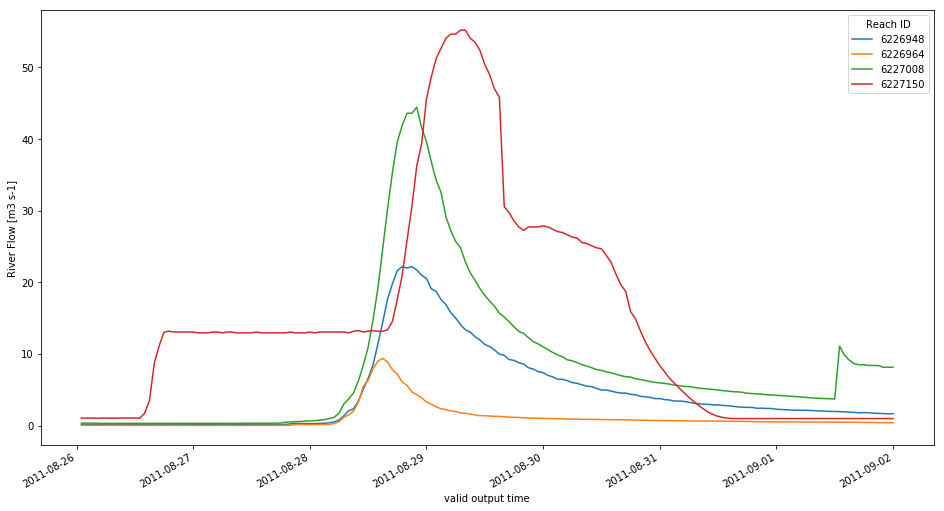

In [48]:
simulation.output.chanobs.streamflow.plot(x='time', hue='feature_id', aspect=2, size=8)

In [ ]:
# Join in routelink gages and hue=gages plot?

Another option is to plot in R reading netcdf files in using `rwrfhydro::xr_datatable` and `ggplot2`.

In [ ]:
# plot the domain?